<h1> Stéganographie par LSB </h1>
<i>par Claudia Delgado et Mehdi Miah - Mars 2017</i>

# Plan 

# Import

In [43]:
from scipy import misc
import numpy as np
import array
from PIL import Image
import time
from numpy.linalg import svd, norm
import matplotlib.pyplot as plt

%matplotlib inline

# Choices of images

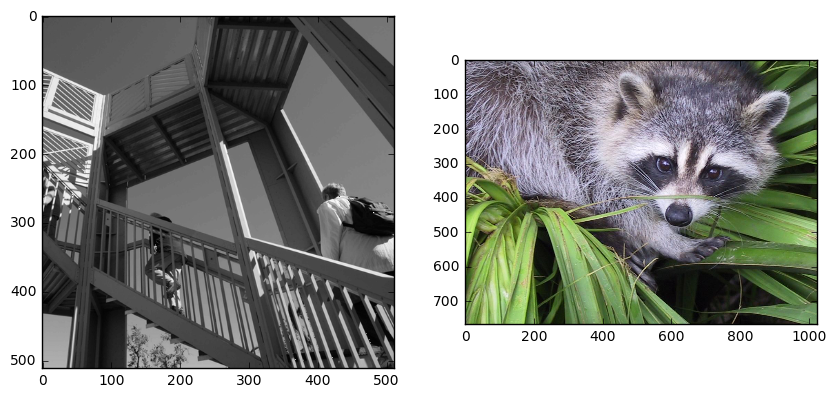

In [3]:
original_carrier = misc.ascent()
original_hidden = misc.face()

plt.figure(figsize = (10,10))
plt.subplot(1, 2, 1)
plt.imshow(original_carrier, cmap=plt.cm.gray)
plt.subplot(1, 2, 2)
plt.imshow(original_hidden)

# Cleaning the images

In [4]:
# Shapes of images
print('The carrier image is', original_carrier.shape)
print('The hidden image is', original_hidden.shape)

The carrier image is (512, 512)
The hidden image is (768, 1024, 3)


In [5]:
# Test if the two inputs have the same size
if original_carrier.shape == original_hidden.shape:
    print('OK, the two inputs have the same dimensions.')
else:
    print('BEWARE, you have to trunc an image.')

    
# Optimal size    
x_min = min(original_carrier.shape[0], original_hidden.shape[0])
y_min = min(original_carrier.shape[1], original_hidden.shape[1])

print('The best dimension size is %.f x %.f.' %(x_min , y_min))

BEWARE, you have to trunc an image.
The best dimension size is 512 x 512.


In [6]:
#Correction of the hidden image (ALAMANO)
hidden = original_hidden[100:(x_min+100), 350:(y_min+350)]
hidden = hidden[:,:,0]
carrier = original_carrier

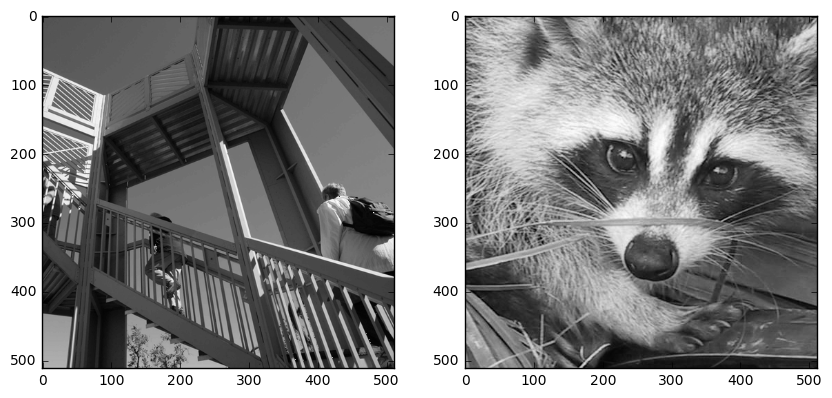

In [7]:
#Cleaned images (same dimensions)
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(carrier, cmap=plt.cm.gray)#, interpolation="none")
plt.subplot(1,2,2)
plt.imshow(hidden, cmap=plt.cm.gray)#, interpolation="none")

In [8]:
#Sanity check
print(carrier.shape == hidden.shape)

True


# Functions to code and decode

In [9]:
def code_steganography_lsb(carrier, hidden, nb_hidden_bit=1):
    '''
    Input : carrier - number between 0 and 255 corresponding to the bit code of the carrier image
          : hidden - number between 0 and 255 corresponding to the bit code of the hidden image
          : nb_hidden_bit - the number of hidden bits
    Output : output - image resulting from the code      
    '''
    #check that the number is an integer between 1 and 7 included
    assert nb_hidden_bit in range(1,8), "nb_hidden_bit should be between 1 and 7"

    #Binary of the carrier
    bin_carrier = format(carrier,'08b')

    #Binary of the hidden
    bin_hidden = format(hidden,'08b')

    #Result of the LSB algorithm
    bin_output = bin_carrier[:-nb_hidden_bit] + bin_hidden[:nb_hidden_bit-8]
    output = int(bin_output, 2)

    return output

In [10]:
def decode_steganography_lsb(output, nb_hidden_bit=1):
    '''
    Input : output - number between 0 and 255 corresponding to the bit code of the output image
          : nb_hidden_bit - the number of hidden bits
    '''
    #check that the number is an integer between 1 and 7 included
    assert nb_hidden_bit in range(1,8), "nb_hidden_bit should be between 1 and 7"

    #Binary of the output
    bin_output = format(output,'08b')

    #Decode the binary code
    #for the carrier
    bin_carrier = bin_output[:8-nb_hidden_bit] + '0'*nb_hidden_bit
    carrier = int(bin_carrier , 2)

    #for the hidden
    bin_hidden = bin_output[-nb_hidden_bit:] + '0'*(8-nb_hidden_bit)
    hidden = int(bin_hidden , 2)

    return carrier, hidden

In [11]:
decode_steganography_lsb(89, nb_hidden_bit=5)

(64, 200)

In [12]:
def msb(image, nb_bits = 3):
    bin_image = format(image,'08b')
    bin_output = bin_image[:nb_bits] + '0'*(8-nb_bits)
    output = int(bin_output, 2)
    
    print(bin_image, bin_output, output)
    
    return(output)

In [13]:
msb(100, nb_bits = 1)

01100100 00000000 0


0

# Application

## Encoding

In [14]:
%%time
#Encode
nb_hidden_bits_encode = 2
output = carrier.copy()
for i in range(carrier.shape[0]):
    for j in range(carrier.shape[1]):
        output[i,j] = code_steganography_lsb(carrier[i,j], hidden[i,j], nb_hidden_bits_encode)

Wall time: 1.15 s


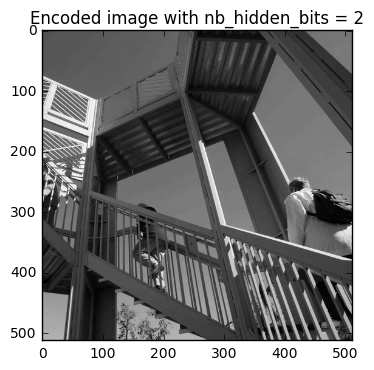

In [15]:
plt.imshow(output, cmap=plt.cm.gray)
plt.title('Encoded image with nb_hidden_bits = %.0f' %nb_hidden_bits_encode)

## Decoding knowing the hyperparameter

In [16]:
%%time
#Decode
nb_hidden_bits_decode = nb_hidden_bits_encode #the best hyperparameter
carrier_decode = output.copy()
hidden_decode = output.copy()
for i in range(output.shape[0]):
    for j in range(output.shape[1]):
        carrier_decode[i,j], hidden_decode[i,j] = decode_steganography_lsb(output[i,j], nb_hidden_bits_decode)

Wall time: 981 ms


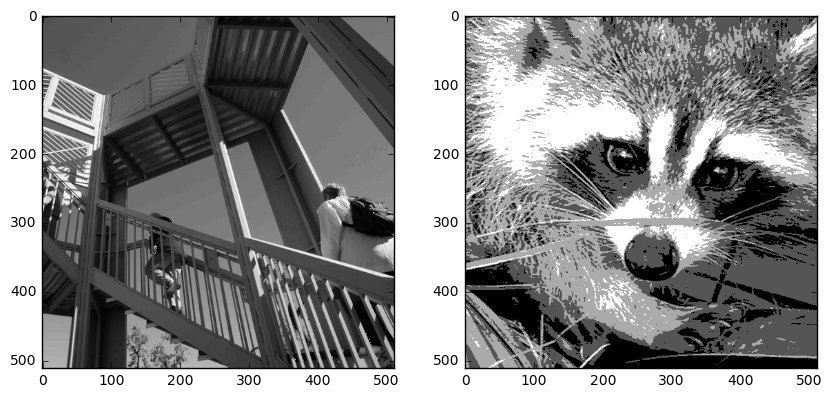

In [17]:
#Decodes images 
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(carrier_decode, cmap=plt.cm.gray)
plt.subplot(1,2,2)
plt.imshow(hidden_decode, cmap=plt.cm.gray)

Here, one knew that the optimal hyperparameter `nb_hidden_bits_decode`.
What happens if one does not know it ?

## Choice of the better hyperparameter `nb_hidden_bits_decode`

In [18]:
%%time

all_carrier_decode = []
all_hidden_decode = []

for nb_hidden_bits_decode in range(1,8):
    #Decode with different values of nb_hidden_bits_decode
    carrier_decode = output.copy()
    hidden_decode = output.copy()

    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            carrier_decode[i,j], hidden_decode[i,j] = decode_steganography_lsb(output[i,j], nb_hidden_bits_decode)
    all_carrier_decode.append(carrier_decode)
    all_hidden_decode.append(hidden_decode)

Wall time: 7.25 s


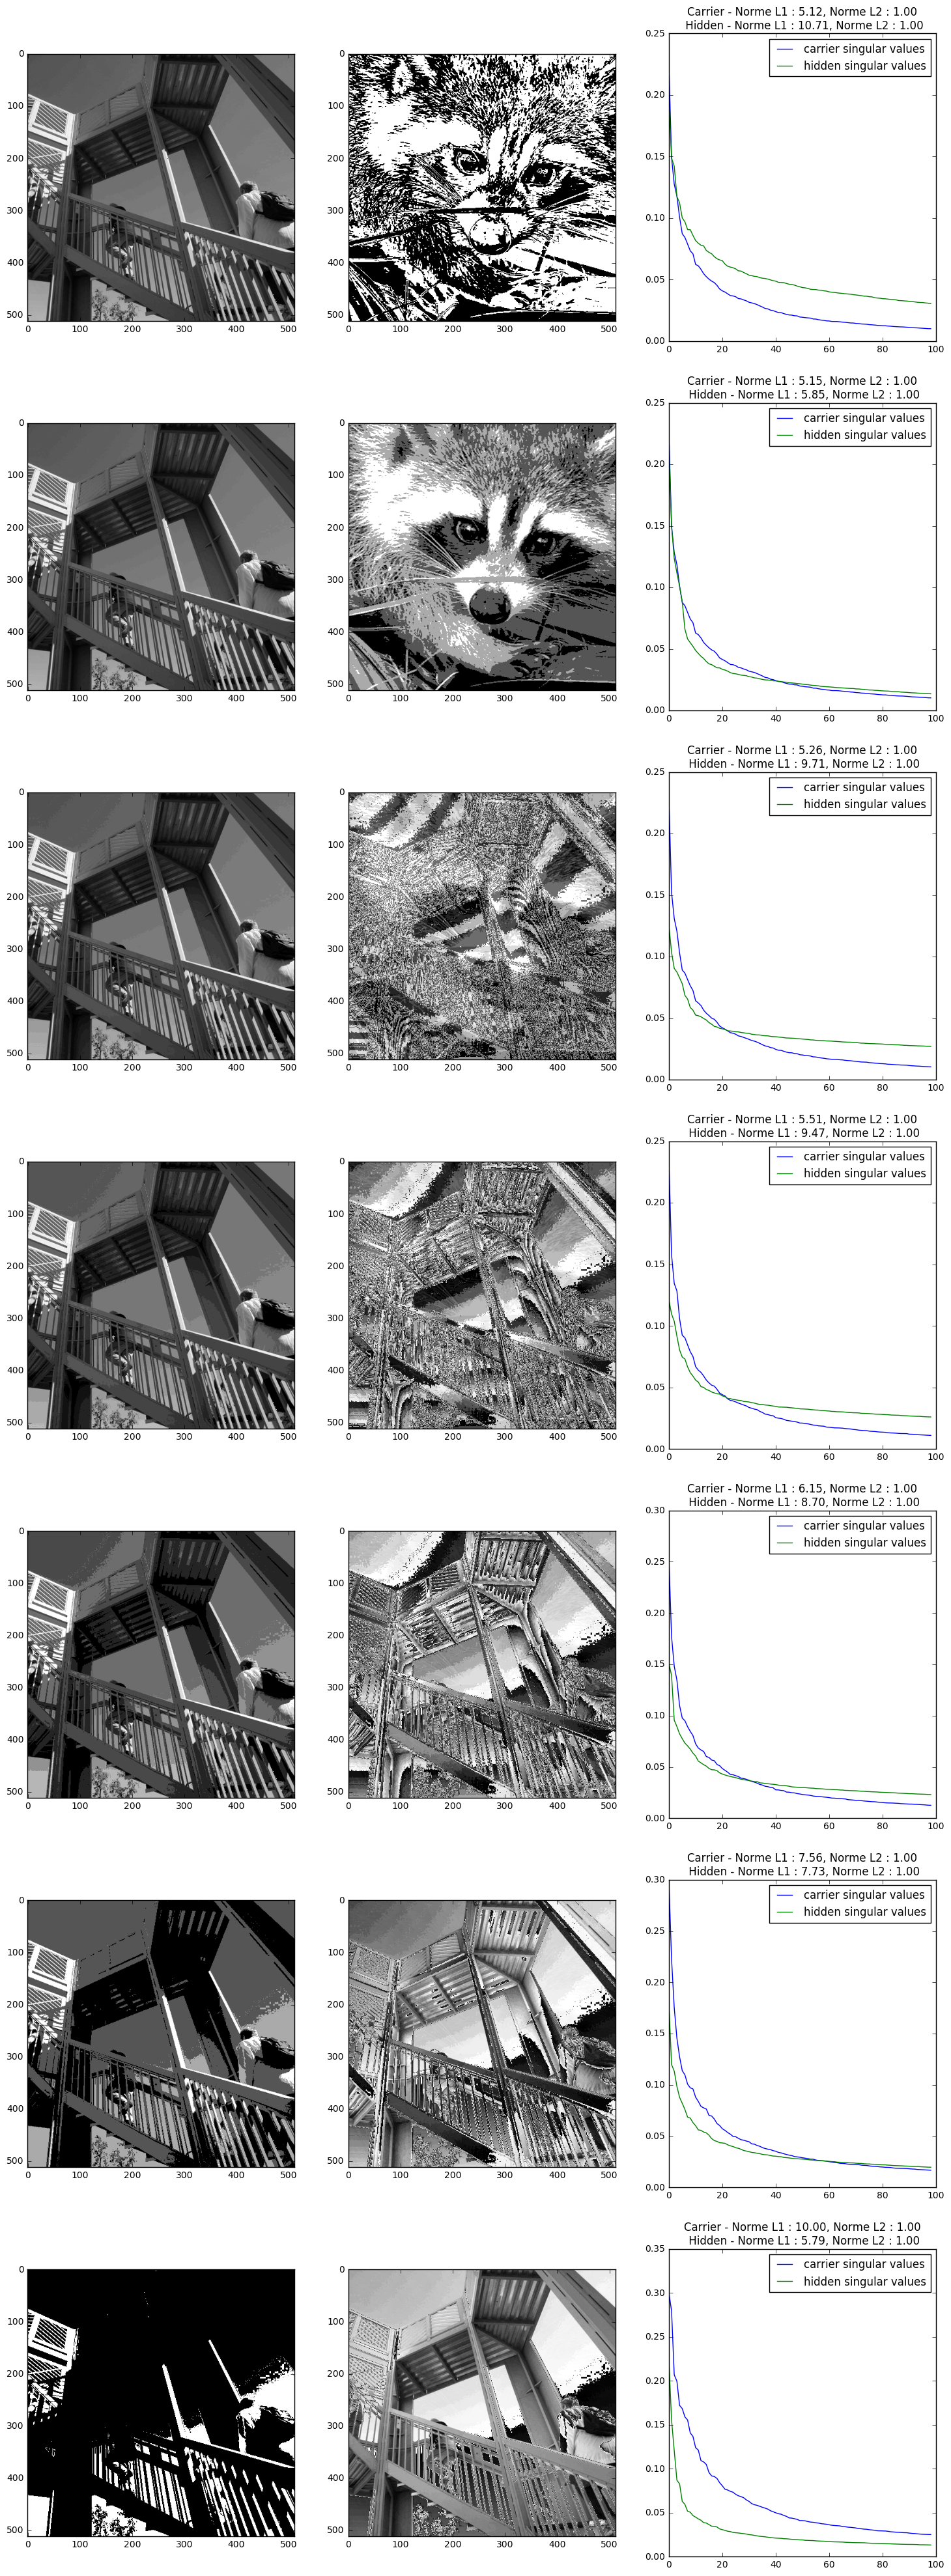

In [19]:
#Decoded images 
plt.figure(figsize = (18,50))
score_bit = []
score_carrier = []
score_hidden = []
for nb_hidden_bits_decode in range(0,7):
    plt.subplot(7,3,nb_hidden_bits_decode*3+1)
    plt.imshow(all_carrier_decode[nb_hidden_bits_decode], cmap=plt.cm.gray)
    plt.subplot(7,3,nb_hidden_bits_decode*3+2)
    plt.imshow(all_hidden_decode[nb_hidden_bits_decode], cmap=plt.cm.gray)
    
    Ucd, Scd, Vcd = svd(all_carrier_decode[nb_hidden_bits_decode])
    Uhd, Shd, Vhd = svd(all_hidden_decode[nb_hidden_bits_decode])
    Scd_normed = Scd/np.linalg.norm(Scd, 2)
    Shd_normed = Shd/np.linalg.norm(Shd, 2)
    plt.subplot(7,3,nb_hidden_bits_decode*3+3)
    plt.plot(Scd_normed[1:100], label = 'carrier singular values')
    plt.plot(Shd_normed[1:100], label = 'hidden singular values')
    plt.title('Carrier - Norme L1 : %.2f, Norme L2 : %.2f\n Hidden - Norme L1 : %.2f, Norme L2 : %.2f' 
              %(np.linalg.norm(Scd_normed,1), np.linalg.norm(Scd_normed, 2),
               np.linalg.norm(Shd_normed,1), np.linalg.norm(Shd_normed, 2)))
    plt.legend()
    
    score = (np.linalg.norm(Scd_normed,1) * np.linalg.norm(Shd_normed,1))
    score_bit.append(score)
    
    score_carrier.append(np.linalg.norm(Scd_normed,1))
    score_hidden.append(np.linalg.norm(Shd_normed,1))


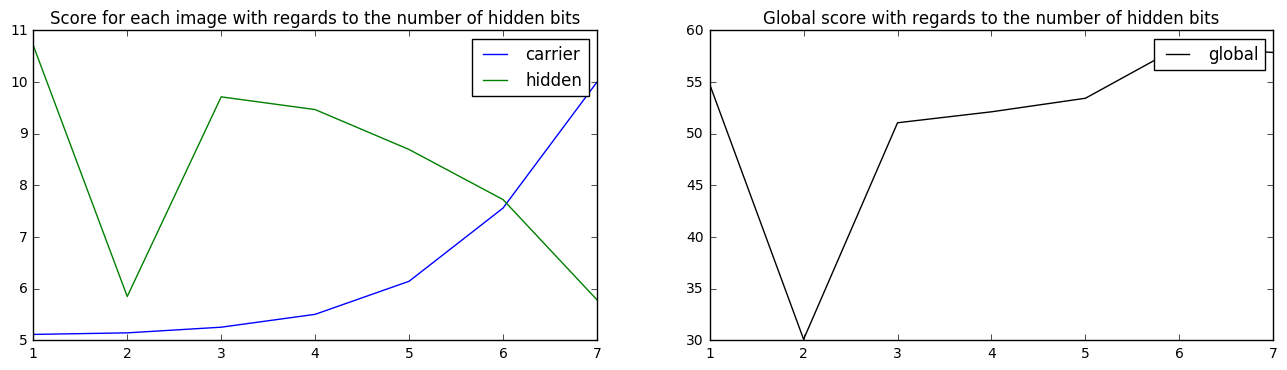

In [20]:
plt.figure(figsize = (16,4))

plt.subplot(1,2,1)
plt.plot(range(1,8), score_carrier, label = 'carrier')
plt.plot(range(1,8), score_hidden,label = 'hidden')
plt.title('Score for each image with regards to the number of hidden bits')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1,8), score_bit, label = 'global', c = 'k')
plt.title('Global score with regards to the number of hidden bits')
plt.legend()

# Test pour le nombre de bits

In [22]:
def nb_plan_V1(image):
    '''
    Input : image - 
    Output : output -      
    '''
    
    
    '''
    - u=pixel[i,j] 
    - v=pixel[i, j+1]
    - A est le nombre de couples u,v tels que u=v
    - B est le nombre de couples u,v tels que (v est pair et u < v) ou (v est impair et u>v)
    - C est le nombre de couples u,v tels que (v est pair et u > v) ou (v est impair et u<v)
    - D est le nombre de couples u,v de C tels que |u-v|=1
    - E = C-D
    - S est le nombre total de couples et S = B+D+E+A = B+C+A
    Si un message est caché, sa longueur relative (proportion de bits modifiés) est 
    donnée par la plus petite racine de l’équation du second degré : 
    (D+A)/2  x^2 + (2*B-S) x – B =0.
    '''
    pixel=image.copy()
    r=[]
    s=[]
    t=[]
    s_bis=[]
    t_bis=[]
    for p in range(8):
        A =0
        B = 0
        C = 0
        D = 0
        for i in range(image.shape[0]):
            for j in range(image.shape[1]-1):
                u= int(format(pixel[i,j] ,'08b')[(8-p-1):8])
                v= int(format(pixel[i, j+1],'08b')[(8-p-1):8])
                A += (u==v)
                B += ((v%2==0) and (u<v)) +  ((v%2==1) and (u>v))
                C += ((v%2==0) and (u>v)) +  ((v%2==1) and (u<v))
                D += ((((v%2==0) and (u>v)) +  ((v%2==1) and (u<v)) ) and (abs(u-v)==1))
                E = C-D
                S = B+C+A
        coeff = [(D+A)/2 , (2*B-S) , -B]
        sol= np.roots(coeff)
        r.append(sol)
        s.extend([i for i in sol if i>0])
        s_bis.append(min([i for i in sol]))
        t.append(s[p]- ((1/(p+1))*(sum(s[:p]))))
        t_bis.append(s_bis[p]- ((1/(p+1))*(sum(s_bis[:p]))))

    u = [(s[i]- s[i+1]) for i in range(7)]
    u_bis = [(s_bis[i]- s_bis[i+1]) for i in range(7)]
    return(r,s,t,u,s_bis,t_bis,u_bis)

In [23]:
def nb_plan_V2(image):
    '''
    Input : image - 
    Output : output -      
    '''
    
    
    '''
    - u=pixel[i,j] 
    - v=pixel[i, j+1]
    - A est le nombre de couples u,v tels que u=v
    - B est le nombre de couples u,v tels que (v est pair et u < v) ou (v est impair et u>v)
    - C est le nombre de couples u,v tels que (v est pair et u > v) ou (v est impair et u<v)
    - D est le nombre de couples u,v de C tels que |u-v|=1
    - E = C-D
    - S est le nombre total de couples et S = B+D+E+A = B+C+A
    Si un message est caché, sa longueur relative (proportion de bits modifiés) est 
    donnée par la plus petite racine de l’équation du second degré : 
    (D+A)/2  x^2 + (2*B-S) x – B =0.
    '''
    pixel=image.copy()
    r=[]
    s=[]
    t=[]
    s_bis=[]
    t_bis=[]
    for p in range(8):
        A =0
        B = 0
        C = 0
        D = 0
        for i in range(image.shape[0]):
            for j in range(image.shape[1]-1):
                u= int(format(pixel[i,j] ,'08b')[:8-p])
                v= int(format(pixel[i, j+1],'08b')[:8-p])
                A += (u==v)
                B += ((v%2==0) and (u<v)) +  ((v%2==1) and (u>v))
                C += ((v%2==0) and (u>v)) +  ((v%2==1) and (u<v))
                D += ((((v%2==0) and (u>v)) +  ((v%2==1) and (u<v)) ) and (abs(u-v)==1))
                E = C-D
                S = B+C+A
        coeff = [(D+A)/2 , (2*B-S) , -B]
        sol= np.roots(coeff)
        r.append(sol)
        s.extend([i for i in sol if i>0])
        s_bis.append(min([i for i in sol]))
        t.append(s[p]- ((1/(p+1))*(sum(s[:p]))))
        t_bis.append(s_bis[p]- ((1/(p+1))*(sum(s_bis[:p]))))

    u = [(s[i]- s[i+1]) for i in range(7)]
    u_bis = [(s_bis[i]- s_bis[i+1]) for i in range(7)]
    return(r,s,t,u,s_bis,t_bis,u_bis)

In [24]:
def nb_plan_V3(image):
    '''
    Input : image - 
    Output : output -      
    '''
    
    
    '''
    - u=pixel[i,j] 
    - v=pixel[i, j+1]
    - A est le nombre de couples u,v tels que u=v
    - B est le nombre de couples u,v tels que (v est pair et u < v) ou (v est impair et u>v)
    - C est le nombre de couples u,v tels que (v est pair et u > v) ou (v est impair et u<v)
    - D est le nombre de couples u,v de C tels que |u-v|=1
    - E = C-D
    - S est le nombre total de couples et S = B+D+E+A = B+C+A
    Si un message est caché, sa longueur relative (proportion de bits modifiés) est 
    donnée par la plus petite racine de l’équation du second degré : 
    (D+A)/2  x^2 + (2*B-S) x – B =0.
    '''
    pixel=image.copy()
    r=[]
    s=[]
    t=[]
    s_bis=[]
    t_bis=[]
    for p in range(8):
        A =0
        B = 0
        C = 0
        D = 0
        for i in range(image.shape[0]):
            for j in range(image.shape[1]-1):
                u= int(format(pixel[i,j] ,'08b')[(8-p-1):])
                v= int(format(pixel[i, j+1],'08b')[(8-p-1):])
                A += (u==v)
                B += ((v%2==0) and (u<v)) +  ((v%2==1) and (u>v))
                C += ((v%2==0) and (u>v)) +  ((v%2==1) and (u<v))
                D += ((((v%2==0) and (u>v)) +  ((v%2==1) and (u<v)) ) and (abs(u-v)==1))
                E = C-D
                S = B+C+A
        coeff = [(D+A)/2 , (2*B-S) , -B]
        sol= np.roots(coeff)
        r.append(sol)
        s.extend([i for i in sol if i>0])
        s_bis.append(min([i for i in sol]))
        t.append(s[p]- ((1/(p+1))*(sum(s[:p]))))
        t_bis.append(s_bis[p]- ((1/(p+1))*(sum(s_bis[:p]))))

    u = [(s[i]- s[i+1]) for i in range(7)]
    u_bis = [(s_bis[i]- s_bis[i+1]) for i in range(7)]
    return(r,s,t,u,s_bis,t_bis,u_bis)

In [31]:
%%time

original_carrier = misc.ascent()
original_hidden = misc.face()

# Optimal size    
x_min = min(original_carrier.shape[0], original_hidden.shape[0])
y_min = min(original_carrier.shape[1], original_hidden.shape[1])

#Correction of the hidden image (ALAMANO)
hidden = original_hidden[100:(x_min+100), 350:(y_min+350)]
hidden = hidden[:,:,0]
carrier = original_carrier

#Correction of the hidden image (ALAMANO)
hidden = original_hidden[100:(x_min+100), 350:(y_min+350)]
hidden = hidden[:,:,0]
carrier = original_carrier

#Encode
nb_hidden_bits_encode = 5
output = image.copy()
for i in range(carrier.shape[0]):
    for j in range(carrier.shape[1]):
        output[i,j] = code_steganography_lsb(carrier[i,j], hidden[i,j], nb_hidden_bits_encode)

nb_plan_V1(output)
# nb_plan_V2(output)
# nb_plan_V3(output)

Wall time: 1.16 s


In [40]:
%%time

original_carrier = misc.ascent()
original_hidden = misc.face()

# Optimal size    
x_min = min(original_carrier.shape[0], original_hidden.shape[0])
y_min = min(original_carrier.shape[1], original_hidden.shape[1])

#Correction of the hidden image (ALAMANO)
hidden = original_hidden[100:(x_min+100), 350:(y_min+350)]
hidden = hidden[:,:,0]
carrier = original_carrier

#Correction of the hidden image (ALAMANO)
hidden = original_hidden[100:(x_min+100), 350:(y_min+350)]
hidden = hidden[:,:,0]
carrier = original_carrier

#Encode
for l in range(1,8):
    nb_hidden_bits_encode = l
    output = image.copy()
    for i in range(carrier.shape[0]):
        for j in range(carrier.shape[1]):
            output[i,j] = code_steganography_lsb(carrier[i,j], hidden[i,j], nb_hidden_bits_encode)
    print('l = ',l)
    print('np.argmax(nb_plan_V2(output)[1]) :',np.argmax(nb_plan_V2(output)[1]))
    print('np.argmax(nb_plan_V2(output)[2]) :',np.argmax(nb_plan_V2(output)[2]))
    print('np.argmax(nb_plan_V2(output)[3]) :',np.argmax(nb_plan_V2(output)[3]))
    print('np.argmax(nb_plan_V2(output)[4]) :',np.argmax(nb_plan_V2(output)[4]))
    print('np.argmax(nb_plan_V2(output)[5]) :',np.argmax(nb_plan_V2(output)[5]))
    print('np.argmax(nb_plan_V2(output)[6]) :',np.argmax(nb_plan_V2(output)[6]))

l =  1
np.argmax(nb_plan_V2(output)[1]) : 0
np.argmax(nb_plan_V2(output)[2]) : 0
np.argmax(nb_plan_V2(output)[3]) : 0
np.argmax(nb_plan_V2(output)[4]) : 7
np.argmax(nb_plan_V2(output)[5]) : 7
np.argmax(nb_plan_V2(output)[6]) : 0
l =  2
np.argmax(nb_plan_V2(output)[1]) : 1
np.argmax(nb_plan_V2(output)[2]) : 0
np.argmax(nb_plan_V2(output)[3]) : 1
np.argmax(nb_plan_V2(output)[4]) : 7
np.argmax(nb_plan_V2(output)[5]) : 7
np.argmax(nb_plan_V2(output)[6]) : 1
l =  3
np.argmax(nb_plan_V2(output)[1]) : 2
np.argmax(nb_plan_V2(output)[2]) : 0
np.argmax(nb_plan_V2(output)[3]) : 2
np.argmax(nb_plan_V2(output)[4]) : 7
np.argmax(nb_plan_V2(output)[5]) : 7
np.argmax(nb_plan_V2(output)[6]) : 2
l =  4
np.argmax(nb_plan_V2(output)[1]) : 3
np.argmax(nb_plan_V2(output)[2]) : 0
np.argmax(nb_plan_V2(output)[3]) : 3
np.argmax(nb_plan_V2(output)[4]) : 7
np.argmax(nb_plan_V2(output)[5]) : 7
np.argmax(nb_plan_V2(output)[6]) : 3
l =  5
np.argmax(nb_plan_V2(output)[1]) : 4
np.argmax(nb_plan_V2(output)[2]) : 0
np.

# VF pour le nombre de bits

In [49]:
def find_nb_bit(image):
    '''
    Input : image - 
    Output : output -      
    '''
    
    
    '''
    - u=pixel[i,j] 
    - v=pixel[i, j+1]
    - A est le nombre de couples u,v tels que u=v
    - B est le nombre de couples u,v tels que (v est pair et u < v) ou (v est impair et u>v)
    - C est le nombre de couples u,v tels que (v est pair et u > v) ou (v est impair et u<v)
    - D est le nombre de couples u,v de C tels que |u-v|=1
    - E = C-D
    - S est le nombre total de couples et S = B+D+E+A = B+C+A
    Si un message est caché, sa longueur relative (proportion de bits modifiés) est 
    donnée par la plus petite racine de l’équation du second degré : 
    (D+A)/2  x^2 + (2*B-S) x – B =0.
    '''
    pixel=image.copy()
    r=[]
    s=[]
    t=[]
    s_bis=[]
    t_bis=[]
    for p in range(8):
        A =0
        B = 0
        C = 0
        D = 0
        for i in range(image.shape[0]):
            for j in range(image.shape[1]-1):
                u= int(format(pixel[i,j] ,'08b')[:8-p])
                v= int(format(pixel[i, j+1],'08b')[:8-p])
                A += (u==v)
                B += ((v%2==0) and (u<v)) +  ((v%2==1) and (u>v))
                C += ((v%2==0) and (u>v)) +  ((v%2==1) and (u<v))
                D += ((((v%2==0) and (u>v)) +  ((v%2==1) and (u<v)) ) and (abs(u-v)==1))
                E = C-D
                S = B+C+A
        coeff = [(D+A)/2 , (2*B-S) , -B]
        sol= np.roots(coeff)
        r.append(sol)
        s_bis.append(min([i for i in sol]))
        t_bis.append(s_bis[p]- ((1/(p+1))*(sum(s_bis[:p]))))

    u_bis = [(s_bis[i]- s_bis[i+1]) for i in range(7)]
    return(np.argmax(u_bis)+1)

In [50]:
%%time

original_carrier = misc.ascent()
original_hidden = misc.face()

# Optimal size    
x_min = min(original_carrier.shape[0], original_hidden.shape[0])
y_min = min(original_carrier.shape[1], original_hidden.shape[1])

#Correction of the hidden image (ALAMANO)
hidden = original_hidden[100:(x_min+100), 350:(y_min+350)]
hidden = hidden[:,:,0]
carrier = original_carrier

#Correction of the hidden image (ALAMANO)
hidden = original_hidden[100:(x_min+100), 350:(y_min+350)]
hidden = hidden[:,:,0]
carrier = original_carrier

#Encode
for l in range(1,8):
    nb_hidden_bits_encode = l
    output = image.copy()
    for i in range(carrier.shape[0]):
        for j in range(carrier.shape[1]):
            output[i,j] = code_steganography_lsb(carrier[i,j], hidden[i,j], nb_hidden_bits_encode)
    print('l = ',l)
    print('find_nb_bit(output) :',find_nb_bit(output))

l =  1
find_nb_bit(output)) : 1
l =  2
find_nb_bit(output)) : 2
l =  3
find_nb_bit(output)) : 3
l =  4
find_nb_bit(output)) : 4
l =  5
find_nb_bit(output)) : 5
l =  6
find_nb_bit(output)) : 6
l =  7
find_nb_bit(output)) : 7
Wall time: 1min 5s
